In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im

In [2]:
class ResidualBlock(nn.Module):
    def __init__ (self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x


class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn


    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x


class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x
        
        
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')
    def forward(self, x):
        x = self.conv(x)
        return x

In [3]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 64, a2n = False):
        super(Generator, self).__init__()
        self.a2n = a2n
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)  
        self.contract1 = ContractingBlock(hidden_channels)  
        self.contract2 = ContractingBlock(hidden_channels*2)
        mult = 4
        self.res0 = ResidualBlock(hidden_channels*mult)
        self.res1 = ResidualBlock(hidden_channels*mult)
        self.res2 = ResidualBlock(hidden_channels*mult)
        self.res3 = ResidualBlock(hidden_channels*mult)
        self.res4 = ResidualBlock(hidden_channels*mult)
        self.res5 = ResidualBlock(hidden_channels*mult)
        self.res6 = ResidualBlock(hidden_channels*mult)
        self.res7 = ResidualBlock(hidden_channels*mult)
        self.res8 = ResidualBlock(hidden_channels*mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        if self.a2n:
            xn = self.downfeature(x13) + x # global shortcut for a2n gen
        else:
            xn = self.downfeature(x13)
        return self.tanh(xn)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

In [5]:
dim_A = 1
dim_B = 1
device = 'cpu'

In [13]:
gen_AB_01 = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_01 = Generator(dim_B, dim_A).to(device)
# gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
# disc_A = Discriminator(dim_A).to(device)
# disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
# disc_B = Discriminator(dim_B).to(device)
# disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
gen_AB_1 = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_1= Generator(dim_B, dim_A).to(device)
# gen_opt_gs = torch.optim.Adam(list(gen_AB_gs.parameters()) + list(gen_BA_gs.parameters()), lr=lr, betas=(0.5, 0.999))
# disc_A_gs = Discriminator(dim_A).to(device)
# disc_A_opt_gs = torch.optim.Adam(disc_A_gs.parameters(), lr=lr, betas=(0.5, 0.999))
# disc_B_gs = Discriminator(dim_B).to(device)
# disc_B_opt_gs = torch.optim.Adam(disc_B_gs.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
gen_AB_10 = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_10= Generator(dim_B, dim_A).to(device)
# gen_opt_gs_al = torch.optim.Adam(list(gen_AB_gs_al.parameters()) + list(gen_BA_gs_al.parameters()), lr=lr, betas=(0.5, 0.999))
# disc_A_gs_al = Discriminator(dim_A).to(device)
# disc_A_opt_gs_al = torch.optim.Adam(disc_A_gs_al.parameters(), lr=lr, betas=(0.5, 0.999))
# disc_B_gs_al = Discriminator(dim_B).to(device)
# disc_B_opt_gs_al = torch.optim.Adam(disc_B_gs_al.parameters(), lr=lr, betas=(0.5, 0.999))

In [16]:
gen_AB_100 = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_100 = Generator(dim_B, dim_A).to(device)

In [6]:
gen_AB_001 = Generator(dim_A, dim_B, a2n=True).to(device)
gen_BA_001 = Generator(dim_B, dim_A).to(device)

In [17]:
pre_dict_01 = torch.load('../Saved Models/ablation/LS-ANT-GAN_20_epochs(BraTs2018).pth')
gen_AB_01.load_state_dict(pre_dict['gen_AB'])
gen_BA_01.load_state_dict(pre_dict['gen_BA'])
# gen_opt.load_state_dict(pre_dict['gen_opt'])
# disc_A.load_state_dict(pre_dict['disc_A'])
# disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
# disc_B.load_state_dict(pre_dict['disc_B'])
# disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

<All keys matched successfully>

In [19]:
pre_dict_1 = torch.load('../Saved Models/ablation/lsantgan_am/LS-ANT-GAN_20_epochs_am_1(BraTs2018).pth')
gen_AB_1.load_state_dict(pre_dict_1['gen_AB'])
gen_BA_1.load_state_dict(pre_dict_1['gen_BA'])
# gen_opt_gs.load_state_dict(pre_dict_gs['gen_opt'])
# disc_A_gs.load_state_dict(pre_dict_gs['disc_A'])
# disc_A_opt_gs.load_state_dict(pre_dict_gs['disc_A_opt'])
# disc_B_gs.load_state_dict(pre_dict_gs['disc_B'])
# disc_B_opt_gs.load_state_dict(pre_dict_gs['disc_B_opt'])

<All keys matched successfully>

In [20]:
pre_dict_10 = torch.load('../Saved Models/ablation/lsantgan_am/LS-ANT-GAN_20_epochs_am_10(BraTs2018).pth')
gen_AB_10.load_state_dict(pre_dict_10['gen_AB'])
gen_BA_10.load_state_dict(pre_dict_10['gen_BA'])
# gen_opt_gs_al.load_state_dict(pre_dict_gs_al['gen_opt'])
# disc_A_gs_al.load_state_dict(pre_dict_gs_al['disc_A'])
# disc_A_opt_gs_al.load_state_dict(pre_dict_gs_al['disc_A_opt'])
# disc_B_gs_al.load_state_dict(pre_dict_gs_al['disc_B'])
# disc_B_opt_gs_al.load_state_dict(pre_dict_gs_al['disc_B_opt'])

<All keys matched successfully>

In [21]:
pre_dict_100 = torch.load('../Saved Models/ablation/lsantgan_am/LS-ANT-GAN_20_epochs_am_100(BraTs2018).pth')
gen_AB_100.load_state_dict(pre_dict_100['gen_AB'])
gen_BA_100.load_state_dict(pre_dict_100['gen_BA'])

<All keys matched successfully>

In [13]:
pre_dict_001 = torch.load('../Saved Models/ablation/lsantgan_am/LS-ANT-GAN_20_epochs_am_0.01(BraTs2018.pth')
gen_AB_001.load_state_dict(pre_dict_001['gen_AB'])
gen_BA_001.load_state_dict(pre_dict_001['gen_BA'])

<All keys matched successfully>

In [14]:
import nibabel as nib
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import glob
import numpy as np
scaler = MinMaxScaler()

In [15]:
# flair_list = sorted(glob.glob('../NormalAndAbnormalImages2018/test/*.*'))
flair_list = sorted(glob.glob('../NormalAndAbnormalImages2018/trainA/*.*'))
# flair_list = sorted(glob.glob('../NormalAndAbnormalImages2018/trainN/*.*'))
masks = sorted(glob.glob('../NormalAndAbnormalImages2018/masks/*.*'))

In [16]:
n=len(flair_list)

## Abnormal to Normal

In [17]:
def translate(abnor, GA2N):
    abnor_arr = torch.from_numpy(abnor)
    abnor_rep = abnor_arr.repeat(1,1,1,1)
    abnor_shifted = (abnor_rep - 0.5)*2
    abnor_shifted = abnor_shifted.to(device, dtype=torch.float)
    nor_shifted = GA2N(abnor_shifted)
    nor = (nor_shifted + 1)/2
    nor = nor.detach().cpu()
    return nor

In [26]:
i = random.randint(0,n) #1501, 116, 2056, 1925, 358, 1655, 657, 757
print(i)
abnor = np.load(flair_list[657])

380


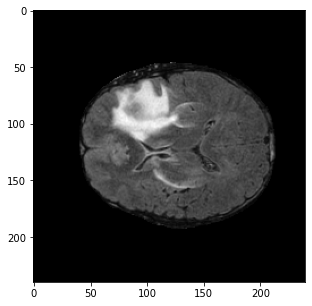

In [39]:
plt.figure(figsize = (5,5))
plt.imshow(abnor, cmap='gray')

In [40]:
trans_nor_01 = translate(abnor, gen_AB_01)
trans_nor_1 = translate(abnor, gen_AB_1)
trans_nor_10 = translate(abnor, gen_AB_10)
trans_nor_100 = translate(abnor, gen_AB_100)

In [27]:
trans_nor_001 = translate(abnor, gen_AB_001)

Text(0.5, 1.0, 'am = 100')

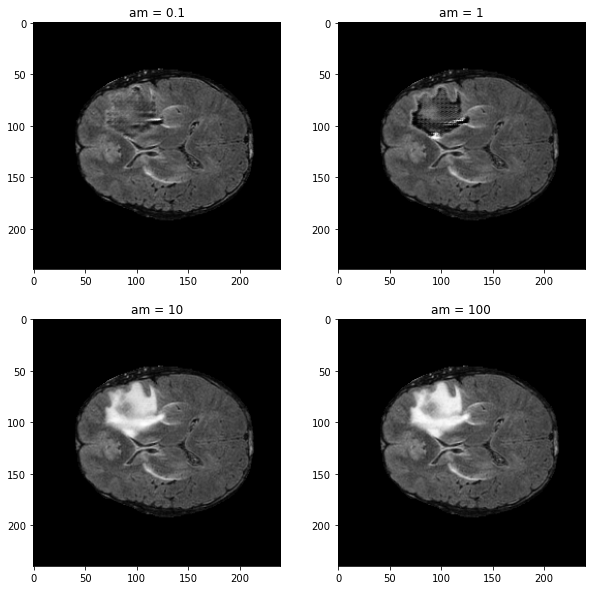

In [41]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(trans_nor_01.squeeze(), cmap = 'gray')
plt.title('am = 0.1')

plt.subplot(222)
plt.imshow(trans_nor_1.squeeze(), cmap = 'gray')
plt.title('am = 1')

plt.subplot(223)
plt.imshow(trans_nor_10.squeeze(), cmap='gray')
plt.title('am = 10')

plt.subplot(224)
plt.imshow(trans_nor_100.squeeze(), cmap='gray')
plt.title('am = 100')

Text(0.5, 1.0, 'am = 0.01')

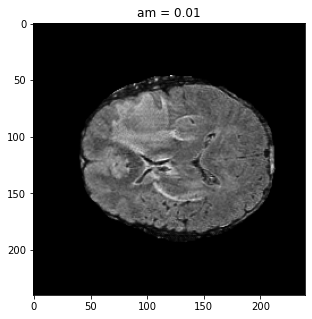

In [28]:
plt.figure(figsize = (5,5))
plt.imshow(trans_nor_001.squeeze(), cmap = 'gray')
plt.title('am = 0.01')

## PSNR dB

In [19]:
def psnrdb(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [20]:
psnr1, psnr2, psnr3, psnr4 = 0.0,0.0,0.0,0.0

In [21]:
rand_ind = torch.randperm(len(flair_list))[:600]

In [46]:
for ind in rand_ind:
    abnor = np.load(flair_list[ind])
    trans_nor_01 = translate(abnor, gen_AB_01)
    trans_nor_1 = translate(abnor, gen_AB_1)
    trans_nor_10 = translate(abnor, gen_AB_10)
    trans_nor_100 = translate(abnor, gen_AB_100)
    
    mask = np.load(masks[ind])
    mask = torch.from_numpy(mask)
    
    psnr1 += psnrdb((1-mask)*abnor.squeeze(), (1-mask)*trans_nor_01.squeeze())
    psnr2 += psnrdb((1-mask)*abnor.squeeze(), (1-mask)*trans_nor_1.squeeze())
    psnr3 += psnrdb((1-mask)*abnor.squeeze(), (1-mask)*trans_nor_10.squeeze())
    psnr4 += psnrdb((1-mask)*abnor.squeeze(), (1-mask)*trans_nor_100.squeeze())

In [47]:
print("PSNR db")
print()
print("am = 0.1 \n", psnr1/600)
print()
print("am = 1 \n", psnr2/600)
print()
print("am = 10 \n", psnr3/600)
print()
print("am = 100 \n", psnr4/600)

PSNR db

am = 0.1 
 tensor(47.1860, dtype=torch.float64)

am = 1 
 tensor(54.7258, dtype=torch.float64)

am = 10 
 tensor(56.8504, dtype=torch.float64)

am = 100 
 tensor(57.4404, dtype=torch.float64)


In [22]:
for ind in rand_ind:
    abnor = np.load(flair_list[ind])
    trans_nor_001 = translate(abnor, gen_AB_001)
    
    mask = np.load(masks[ind])
    mask = torch.from_numpy(mask)
    
    psnr1 += psnrdb((1-mask)*abnor.squeeze(), (1-mask)*trans_nor_001.squeeze())
    
print("am = 0.01 \n", psnr1/600)

am = 0.01 
 tensor(35.3064, dtype=torch.float64)


## Normal to Abnormal

In [17]:
def translate2A(abnor, GN2A):
    nor_arr = torch.from_numpy(nor)
    nor_rep = nor_arr.repeat(1,1,1,1)
    nor_shifted = (nor_rep - 0.5)*2
    nor_shifted = nor_shifted.to(device, dtype=torch.float)
    abnor_shifted = GN2A(nor_shifted)
    abnor = (abnor_shifted + 1)/2
    abnor = abnor.detach().cpu()
    return abnor

In [134]:
i = random.randint(0,n) #1501, 116, 2056, 1925, 358, 1655
print(i)
nor = np.load(flair_list[1501])
trans_abnor = translate2A(nor, gen_BA)
trans_abnor_gs = translate2A(nor, gen_BA_gs)
trans_abnor_gs_al = translate2A(nor, gen_BA_gs_al)
trans_abnor_gs_al_ls = translate2A(nor, gen_BA_gs_al_ls)

1590


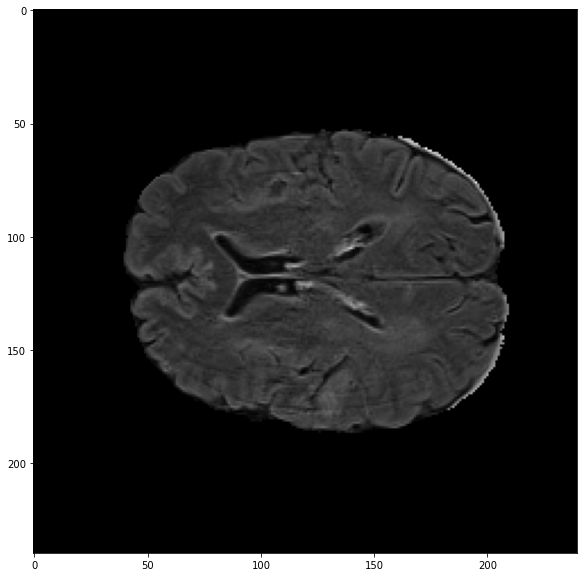

In [135]:
plt.figure(figsize = (10,10))
plt.imshow(nor, cmap='gray')

Text(0.5, 1.0, 'cyclegan using least squares + global shortcut + anomaly loss (Ours)')

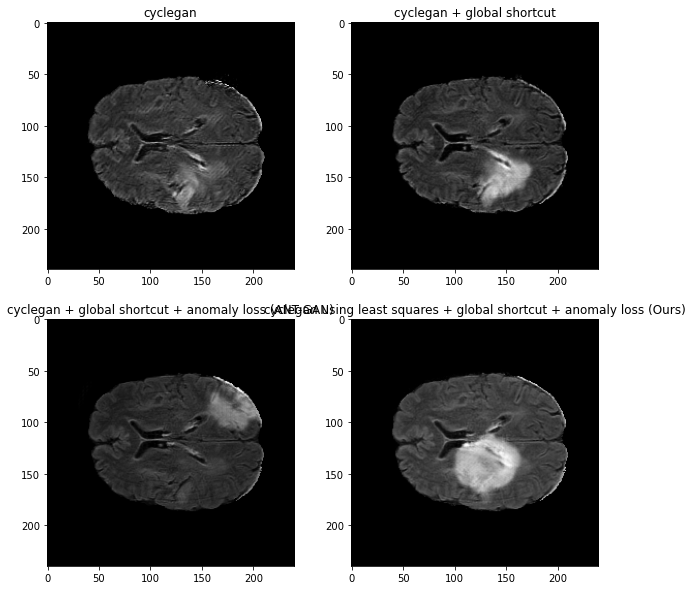

In [137]:
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(trans_abnor.squeeze(), cmap = 'gray')
plt.title('cyclegan')

plt.subplot(222)
plt.imshow(trans_abnor_gs.squeeze(), cmap = 'gray')
plt.title('cyclegan + global shortcut')

plt.subplot(223)
plt.imshow(trans_abnor_gs_al.squeeze(), cmap='gray')
plt.title('cyclegan + global shortcut + anomaly loss (ANT-GAN)')

plt.subplot(224)
plt.imshow(trans_abnor_gs_al_ls.squeeze(), cmap='gray')
plt.title('cyclegan using least squares + global shortcut + anomaly loss (Ours)')